# Import Packages

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [2]:
data = pd.read_csv('train.csv')
data.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


- Replace the more than 5 strings with the int 6

In [3]:
data['No_of_previous_employers'] = data['No_of_previous_employers'].replace('More than 5', 6).astype('int64')

In [4]:
#convert all the object df to integers 2

columns = ['Division', 'Qualification', 'Gender',
        'Channel_of_Recruitment', 'State_Of_Origin', 'Foreign_schooled',
        'Marital_Status', 'Past_Disciplinary_Action',
        'Previous_IntraDepartmental_Movement']

label_encode = LabelEncoder()
for col in columns:
    data[col] = label_encode.fit_transform(data[col].astype(str))
    

- Perform One hot encoding on the selected columns

In [5]:
data['Age_of_Employment'] = data['Year_of_recruitment'] - data['Year_of_birth']

- Create a new feature called age of employment.

In [6]:
data.drop(columns=['EmployeeNo', 'Year_of_recruitment', 'Year_of_birth'], inplace=True)

- Drop all unnecessary columns

In [7]:
y = data['Promoted_or_Not']

data = data.drop(data[['Promoted_or_Not']], axis=1)

- Segment and splt the data into train and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=1)

In [9]:
from imblearn.over_sampling import ADASYN 
sm = ADASYN()
X_train_sampled,y_train_sampled = sm.fit_sample(X_train, y_train)

Using TensorFlow backend.


Tried usng ADASYN to handle imbalanced classes

- First tried Random forest model and trained on the sampled data

In [10]:
rf = RandomForestClassifier( 
                            random_state=1)
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [11]:
rf_predict = rf.predict(X_test)
print('The training score is {}'.format(rf.score(X_train, y_train)))
print('The Test Score is {}'.format(accuracy_score(y_test, rf_predict)))

The training score is 0.9922672844138472
The Test Score is 0.9239201357170821


- The training score is 99% and the test score is 92%
- This indicates a high variance. But for this particular use case our focus will be on the F1 score

In [12]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7013
           1       0.66      0.21      0.32       650

    accuracy                           0.92      7663
   macro avg       0.80      0.60      0.64      7663
weighted avg       0.91      0.92      0.91      7663



In [13]:
fpr, tpr, thresholds = roc_curve(y_test, rf_predict)
roc_auc = auc(fpr, tpr)
print('The Roc-Auc score is {}'.format(roc_auc))

The Roc-Auc score is 0.6017897530958989


- AUC score is pretty low.

In [14]:
f1_scoress = f1_score(y_test, rf_predict, average='micro')
print('F1 score is {}'.format(f1_scoress))

F1 score is 0.9239201357170821


-The F1 score of 92% is a good one

In [15]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [16]:
feature_importances.plot(kind='bar')

In [17]:
feature_importances[feature_importances['importance'] > 0.05]

,importance
Targets_met,0.224983
No_of_previous_employers,0.124621
Channel_of_Recruitment,0.098718
Training_score_average,0.090916
Gender,0.079270
Last_performance_score,0.059969
Division,0.056168
Previous_Award,0.051943


- After plotting the feature importance. 7 features featured among the most important feature beating the threshold of 0.005.
- We will pick the most important features to build the model.

# Building Models Usng the important Feature

In [18]:
columns = ['Targets_met', 'No_of_previous_employers', 'Channel_of_Recruitment', 'Training_score_average',
           'Last_performance_score', 'Gender', 'Previous_Award']

In [19]:
new_df = data[columns]
new_df.head()

,Targets_met,No_of_previous_employers,Channel_of_Recruitment,Training_score_average,Last_performance_score,Gender,Previous_Award
0,1,0,1,41,12.5,0,0
1,0,0,0,52,12.5,1,0
2,0,0,1,42,7.5,1,0
3,0,1,0,42,2.5,1,0
4,0,1,1,77,7.5,1,0


In [20]:
train_x, test_x, train_y, test_y = train_test_split(new_df, y, test_size=0.2, stratify=y, random_state=1)

In [21]:
from imblearn.over_sampling import ADASYN 
sm = ADASYN()
train_x_sampled,train_y_sampled = sm.fit_sample(train_x, train_y)

In [22]:
rf = RandomForestClassifier(n_estimators=300, max_depth=4, min_samples_split=2, class_weight='balanced',
                            random_state=1)
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [23]:
new_predict = rf.predict(test_x)

print('The training score is {}'.format(rf.score(train_x, train_y)))
print('The Test Score is {}'.format(accuracy_score(test_y, new_predict)))

The training score is 0.6721589611406571
The Test Score is 0.6695811040062639


In [24]:
fpr, tpr, thresholds = roc_curve(test_y, new_predict)
roc_auc = auc(fpr, tpr)
print('The Roc-Auc score is {}'.format(roc_auc))

The Roc-Auc score is 0.7550993022007515


- AUC score is better than the first model.

In [25]:
print(classification_report(test_y, new_predict))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      7015
           1       0.19      0.86      0.31       648

    accuracy                           0.67      7663
   macro avg       0.58      0.76      0.54      7663
weighted avg       0.91      0.67      0.74      7663



In [26]:
f1_scores = f1_score(test_y, new_predict, average='micro')
print('F1 score is {}'.format(f1_scores))

F1 score is 0.6695811040062639


- The F1 score performs badly compared to the first model.

In [45]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances[feature_importances['importance'] > 0.05]

,importance
Targets_met,0.404483
Training_score_average,0.286233
Last_performance_score,0.178684
Previous_Award,0.121450


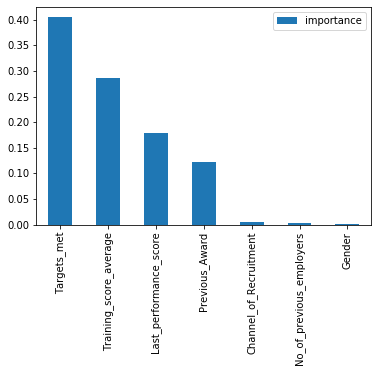

In [30]:
feature_importances.plot(kind='bar')

- The feature importance tells us how relevant each feature was

# Save the First Model

In [31]:
filename = 'model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [32]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_x, test_y)
print(result)

0.6695811040062639


# Build an Xgboos Model

- The xgboost model was built with some parameter set. This was after various hyperparameter tuning

In [33]:
xgb_model = XGBClassifier(
                          n_estimators=4000,
                          max_depth=5,
                          learning_rate=0.01,
                          objective='binary:logistic',
                          subsample=0.87,
                          reg_lambda=0.028)

xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=4000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.028, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.87, verbosity=1)

- Prediction shows that the model is very okay in terms of accuracy. There is a balance between the train and test score

In [44]:
xgb_predict = xgb_model.predict(test_x)

print('The training score is {}'.format(xgb_model.score(train_x, train_y)))
print('The Test Score is {}'.format(accuracy_score(test_y, xgb_predict)))

0.9325263466997292
0.925486102048806
The training score is 0.9325263466997292
The Test Score is 0.925486102048806


In [35]:
print(classification_report(test_y, xgb_predict))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7015
           1       0.73      0.19      0.30       648

    accuracy                           0.93      7663
   macro avg       0.83      0.59      0.63      7663
weighted avg       0.91      0.93      0.90      7663



In [36]:

f1_score(y_test, xgb_predict, average='micro')

0.8970377136891556

- The F1 score is very better than the above. Seem like this is the best model so far.

In [38]:
feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                   index = train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

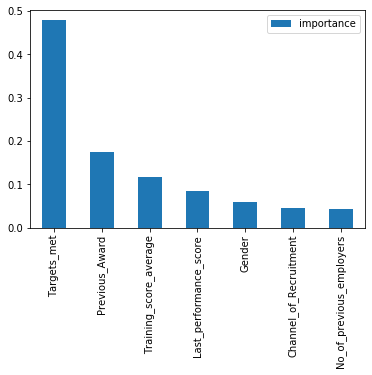

In [39]:
feature_importances.plot(kind='bar')

# Save model for Deployment

In [40]:
filename = 'xgb_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [41]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_x, test_y)
print(result)

0.6695811040062639
